Importing Libraries

In [2]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
from copy import deepcopy
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("CUDA device name:", torch.cuda.get_device_name(0))

Using device: cuda
CUDA device name: NVIDIA GeForce RTX 3070 Ti Laptop GPU


In [16]:
def to_device(tensor):
    return tensor.to(device)

Class for connect4 environment

In [3]:
class Connect4Env:
    def __init__(self):
        self.rows = 6
        self.cols = 7
        self.reset()

    def reset(self):
        self.board = np.zeros((self.rows, self.cols), dtype=int)
        self.current_player = 1
        self.last_move = None
        return self._get_obs()

    def _get_obs(self):
        return self.board[::-1].copy() * self.current_player  # Flip vertically for model input

    def valid_actions(self):
        return [c for c in range(self.cols) if self.board[0, c] == 0]

    def step(self, action):
        if action not in self.valid_actions():
            return self._get_obs(), -10, True, {}

        for r in range(self.rows - 1, -1, -1):
            if self.board[r, action] == 0:
                self.board[r, action] = self.current_player
                self.last_move = (r, action)
                break

        if self._check_winner(self.current_player, self.last_move):
            return self._get_obs(), 1, True, {}

        if len(self.valid_actions()) == 0:
            return self._get_obs(), 0, True, {}

        self.current_player *= -1

        return self._get_obs(), 0, False, {}

    def _check_winner(self, player, last_move):
        if last_move is None:
            return False
        r, c = last_move
        directions = [(1, 0), (0, 1), (1, 1), (1, -1)]
        for dr, dc in directions:
            count = 1
            for d in [-1, 1]:
                nr, nc = r + d * dr, c + d * dc
                while 0 <= nr < self.rows and 0 <= nc < self.cols and self.board[nr, nc] == player:
                    count += 1
                    if count >= 4:
                        return True
                    nr += d * dr
                    nc += d * dc
        return False

    def render(self):
        print("\n".join(" ".join(str(cell) for cell in row) for row in self.board))



Model

In [ ]:
class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 6 * 7, 128)
        self.out = nn.Linear(128, 7)

    def forward(self, x):
        x = x.view(-1, 1, 6, 7).to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.out(x)

Replay Buffer

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, *transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return map(np.array, zip(*batch))

    def __len__(self):
        return len(self.buffer)

Selecting Action

In [17]:
# --- Training Functions ---
def select_action(state, model, epsilon, valid_actions):
    if random.random() < epsilon:
        return random.choice(valid_actions)
    with torch.no_grad():
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        q_values = model(state_tensor)
        for a in range(7):
            if a not in valid_actions:
                q_values[0][a] = -float('inf')
        return torch.argmax(q_values).item()

Optimizing

In [27]:
def optimize(model, target_model, buffer, optimizer, batch_size, gamma):
    if len(buffer) < batch_size:
        return
    states, actions, rewards, next_states, dones = buffer.sample(batch_size)

    states = torch.tensor(states, dtype=torch.float32).to(device)
    actions = torch.tensor(actions, dtype=torch.int64).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
    dones = torch.tensor(dones, dtype=torch.float32).to(device)

    q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze()
    with torch.no_grad():
        next_q_values = target_model(next_states).max(1)[0]
    targets = rewards + gamma * next_q_values * (1 - dones)

    loss = F.mse_loss(q_values, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Training Loop

In [28]:
def train_self_play(episodes=5000, batch_size=64, gamma=0.99, lr=1e-3, epsilon_decay=0.999):
    model = DQN().to(device)
    target_model = deepcopy(model).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    buffer = ReplayBuffer()

    epsilon = 1.0
    rewards_history = []
    win_count, loss_count, draw_count = 0, 0, 0

    for ep in range(episodes):
        env = Connect4Env()
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            valid_actions = env.valid_actions()
            action = select_action(state, model, epsilon, valid_actions)
            next_state, reward, done, _ = env.step(action)
            buffer.push(state, action, reward, next_state, done)
            optimize(model, target_model, buffer, optimizer, batch_size, gamma)
            state = next_state
            total_reward += reward

        if reward == 1:
            win_count += 1
        elif reward == -1:
            loss_count += 1
        else:
            draw_count += 1

        if ep % 50 == 0:
            target_model.load_state_dict(model.state_dict())

        epsilon = max(0.05, epsilon * epsilon_decay)
        rewards_history.append(total_reward)

        if ep % 100 == 0:
            print(f"Ep {ep} | Reward: {total_reward:.2f} | Epsilon: {epsilon:.3f} | Wins: {win_count} | Losses: {loss_count} | Draws: {draw_count}")

    plt.plot(rewards_history)
    plt.title("Total Reward per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.show()

    return model

Train It

Ep 0 | Reward: 1.00 | Epsilon: 0.999 | Wins: 1 | Losses: 0 | Draws: 0
Ep 100 | Reward: 1.00 | Epsilon: 0.904 | Wins: 100 | Losses: 0 | Draws: 1
Ep 200 | Reward: 1.00 | Epsilon: 0.818 | Wins: 200 | Losses: 0 | Draws: 1
Ep 300 | Reward: 1.00 | Epsilon: 0.740 | Wins: 300 | Losses: 0 | Draws: 1
Ep 400 | Reward: 1.00 | Epsilon: 0.670 | Wins: 400 | Losses: 0 | Draws: 1
Ep 500 | Reward: 1.00 | Epsilon: 0.606 | Wins: 500 | Losses: 0 | Draws: 1
Ep 600 | Reward: 1.00 | Epsilon: 0.548 | Wins: 600 | Losses: 0 | Draws: 1
Ep 700 | Reward: 1.00 | Epsilon: 0.496 | Wins: 700 | Losses: 0 | Draws: 1
Ep 800 | Reward: 1.00 | Epsilon: 0.449 | Wins: 799 | Losses: 0 | Draws: 2
Ep 900 | Reward: 1.00 | Epsilon: 0.406 | Wins: 899 | Losses: 0 | Draws: 2
Ep 1000 | Reward: 1.00 | Epsilon: 0.367 | Wins: 999 | Losses: 0 | Draws: 2
Ep 1100 | Reward: 1.00 | Epsilon: 0.332 | Wins: 1097 | Losses: 0 | Draws: 4
Ep 1200 | Reward: 1.00 | Epsilon: 0.301 | Wins: 1197 | Losses: 0 | Draws: 4
Ep 1300 | Reward: 1.00 | Epsilon: 0.2

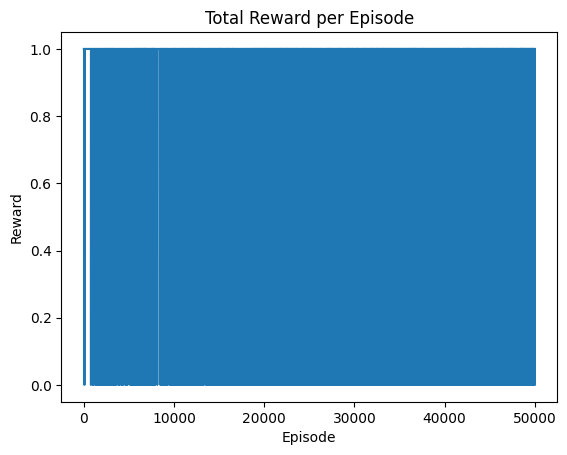

Model saved to connect4_model_weights.pth


In [33]:
trained_model = train_self_play(episodes=50000)
save_model(trained_model)

In [22]:
def save_model(model, path="connect4_model_weights.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

Load Weights

In [12]:
def load_trained_model(path="connect4_model_weights.pth"):
    model = DQN().to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()  # Set to evaluation mode
    print(f"Loaded model from {path}")
    return model

In [30]:
trained_model = load_trained_model()

Loaded model from connect4_model_weights.pth


Playing

In [34]:
def play_against_model(model):
    env = Connect4Env()
    user_starts = input("Do you want to go first? (y/n): ").lower().startswith("y")

    state = env.reset()
    done = False

    while not done:
        env.render()
        print("----------")
        if (env.current_player == 1 and user_starts) or (env.current_player == -1 and not user_starts):
            try:
                action = int(input("Your move (0-6): "))
            except ValueError:
                print("Invalid input. Try again.")
                continue
            if action not in env.valid_actions():
                print("Invalid move. Try again.")
                continue
        else:
            action = select_action(state, model, epsilon=0.0, valid_actions=env.valid_actions())
            print(f"Model plays: {action}")

        state, reward, done, _ = env.step(action)

    env.render()
    if reward == -1:
        print("You win!" if (env.current_player == -1 and user_starts) or (env.current_player == 1 and not user_starts) else "Model wins!")
    elif reward == 1:
        print("Model wins!" if (env.current_player == -1 and user_starts) or (env.current_player == 1 and not user_starts) else "You win!")
    else:
        print("It's a draw!")

In [ ]:
play_against_model(trained_model)

0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 0 0 0 0 0
----------
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 0 1 0 0 0
----------
Model plays: 5
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 0 1 0 -1 0
----------
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 1 1 0 -1 0
----------
Model plays: 5
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 0 0 0 -1 0
0 0 1 1 0 -1 0
----------
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 0 1 0 -1 0
0 0 1 1 0 -1 0
----------
Model plays: 5
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 0 0 0 -1 0
0 0 0 1 0 -1 0
0 0 1 1 0 -1 0
----------
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 0 0 0 1 0
0 0 0 0 0 -1 0
0 0 0 1 0 -1 0
0 0 1 1 0 -1 0
----------
Model plays: 5
0 0 0 0 0 0 0
0 0 0 0 0 -1 0
0 0 0 0 0 1 0
0 0 0 0 0 -1 0
0 0 0 1 0 -1 0
0 0 1 1 0 -1 0
----------
0 0 0 0 0 1 0
0 0 0 0 0 -1 0
0 0 0 0 0 1 0
0 0 0 0 0 -1 0
0 0 0 1 0 -